# Predicting Shelter Animal Outcomes

In [150]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import scipy.stats as stats


%matplotlib inline
import seaborn as sns

In [3]:
data = pd.read_csv("train.csv")
print(data.shape)
print(data.dtypes)

(26729, 10)
AnimalID          object
Name              object
DateTime          object
OutcomeType       object
OutcomeSubtype    object
AnimalType        object
SexuponOutcome    object
AgeuponOutcome    object
Breed             object
Color             object
dtype: object


In [4]:
data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [6]:
data.isnull().sum()

AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64

In [40]:
data.OutcomeType.value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64

## 1. Formatting and Analyzing Individual Features
Before I start predicting outcomes, I need to format features to be suitable for analyses and see their individual relationship to the outcomes. 

### a. Animal Type

In [21]:
AnimalTypeGroup = data.groupby('AnimalType')
AnimalTypeGroup.OutcomeType.value_counts() / data.AnimalType.value_counts().sum()

AnimalType  OutcomeType    
Cat         Transfer           0.205956
            Adoption           0.159826
            Euthanasia         0.026563
            Return_to_owner    0.018706
            Died               0.005500
Dog         Adoption           0.243069
            Return_to_owner    0.160350
            Transfer           0.146545
            Euthanasia         0.031614
            Died               0.001871
Name: OutcomeType, dtype: float64

In [24]:
# convert animal type to binary value
# Dog = 1, Cat = 0
data["AnimalTypeNum"] = pd.get_dummies(data.AnimalType).astype(int)['Dog']

#(data.AnimalType=='Dog').astype(int) 

In [22]:
data.AnimalType.value_counts()

Dog    15595
Cat    11134
Name: AnimalType, dtype: int64

In [25]:
data.AnimalTypeNum.value_counts()

1    15595
0    11134
Name: AnimalTypeNum, dtype: int64

### b. Format DateTime

In [26]:
#format Datetime
data['DateTime'] = pd.to_datetime(data['DateTime'])

In [27]:
dataAge = data.AgeuponOutcome.tolist()

In [33]:
# create list of age in days
AgeinDays = []
for i in dataAge:
    try:
        num = (i.split()[0])
        letter = (i.split()[1][0])
        if(letter == 'y'):
            days = int(num)*365
        elif(letter == 'm'):
            days = int(num)*30
        elif(letter == 'w'):
            days = int(num)*7
        else:
            days = int(num)
        AgeinDays.append(days)
    except:
        AgeinDays.append(np.nan)

In [34]:
# check list
AgeinDays[:20]

[365,
 365,
 730,
 21,
 730,
 30,
 21,
 21,
 150,
 365,
 730,
 730,
 1460,
 730,
 365,
 90,
 21,
 14,
 730,
 365]

In [35]:
# append numerical age column to data set
data['AgeinDays'] = AgeinDays

In [38]:
data.AgeinDays.isnull().sum()

18

In [42]:
age_median =  data.AgeinDays.median()
age_median

365.0

In [43]:
data.AgeinDays.fillna(age_median, inplace=True)
data.AgeinDays.isnull().sum()

0

In [44]:
del data['AgeuponOutcome']
data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,Breed,Color,AnimalTypeNum,AgeinDays
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,Shetland Sheepdog Mix,Brown/White,1,365.0
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,Domestic Shorthair Mix,Cream Tabby,0,365.0
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,Pit Bull Mix,Blue/White,1,730.0
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,Domestic Shorthair Mix,Blue Cream,0,21.0
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,Lhasa Apso/Miniature Poodle,Tan,1,730.0


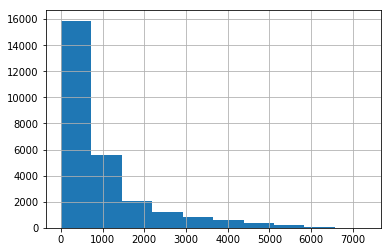

In [45]:
data.AgeinDays.hist()

### c. Breed Data

In [48]:
# create column to identify mixed breeds
mixMask = ['Mix' in breed for breed in data.Breed.tolist()]
mixMask[:10]

[True, True, True, True, False, False, True, True, True, False]

In [50]:
data['MixedBreed'] = mixMask
data.MixedBreed = data.MixedBreed.astype(int)
data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,Breed,Color,AnimalTypeNum,AgeinDays,MixedBreed
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,Shetland Sheepdog Mix,Brown/White,1,365.0,1
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,Domestic Shorthair Mix,Cream Tabby,0,365.0,1
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,Pit Bull Mix,Blue/White,1,730.0,1
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,Domestic Shorthair Mix,Blue Cream,0,21.0,1
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,Lhasa Apso/Miniature Poodle,Tan,1,730.0,0


In [87]:
(data.Breed.value_counts()/data.shape[0]).cumsum()

Domestic Shorthair Mix                                 0.329605
Pit Bull Mix                                           0.400913
Chihuahua Shorthair Mix                                0.466983
Labrador Retriever Mix                                 0.517977
Domestic Medium Hair Mix                               0.549366
German Shepherd Mix                                    0.570878
Domestic Longhair Mix                                  0.590333
Siamese Mix                                            0.604886
Australian Cattle Dog Mix                              0.618616
Dachshund Mix                                          0.630514
Boxer Mix                                              0.639680
Miniature Poodle Mix                                   0.648397
Border Collie Mix                                      0.656964
Australian Shepherd Mix                                0.663063
Catahoula Mix                                          0.668936
Rat Terrier Mix                         

### d. Sex and Sterilization

Sex and Sterilization are two distinct features so it makes more sense to separate it into two columns instead of individual dummy columns. 

In [55]:
data.SexuponOutcome.value_counts()

Neutered Male    9779
Spayed Female    8820
Intact Male      3525
Intact Female    3511
Unknown          1093
9779                1
Name: SexuponOutcome, dtype: int64

In [154]:
data.SexuponOutcome.replace(to_replace= 9779, value= "Unknown", inplace=True)

In [152]:
# Fill missing value
most_frequent = data.SexuponOutcome.value_counts()[0]
data.SexuponOutcome.fillna(most_frequent, inplace=True)
data.SexuponOutcome.value_counts()

Neutered Male    9779
Spayed Female    8820
Intact Male      3525
Intact Female    3511
Unknown          1094
Name: SexuponOutcome, dtype: int64

In [68]:
# Separate SexuponOutcome column into Sex and Neutered/Spayed 
# Female = 1 and Intact = 1
sexMask = ['Female' in sex for sex in data.SexuponOutcome.tolist()]
sterileMask = ['Intact' in fix for fix in data.SexuponOutcome.tolist()]

In [83]:
data['Sex'] = sexMask
data['Sterile'] = sterileMask
data.Sex = data.Sex.astype(int)
data.Sterile = data.Sterile.astype(int)

In [85]:
data.Sex.value_counts() 

0    14398
1    12331
Name: Sex, dtype: int64

In [86]:
data.Sterile.value_counts()

0    19693
1     7036
Name: Sterile, dtype: int64

### e. Color

In [88]:
data.Color.value_counts()

Black/White                    2824
Black                          2292
Brown Tabby                    1635
Brown Tabby/White               940
White                           931
Brown/White                     884
Orange Tabby                    841
Tan/White                       773
Tricolor                        752
Blue/White                      702
Black/Tan                       672
White/Black                     643
Brown                           639
Tan                             628
White/Brown                     569
Tortie                          530
Calico                          517
Orange Tabby/White              455
Blue                            450
Brown Brindle/White             450
Black/Brown                     436
Blue Tabby                      433
White/Tan                       389
Red                             337
Torbie                          335
Brown/Black                     333
Red/White                       331
Blue Tabby/White            

In [122]:
data[['FirstColor','SecondColor']] = data.Color.str.split("/", expand=True)
print(data.FirstColor.nunique())
data.FirstColor.value_counts().sum()

57


26729

In [125]:
data.SecondColor.value_counts().sum()

13924

In [121]:
AnimalTypeGroup.FirstColor.value_counts()

AnimalType  FirstColor     
Cat         Brown Tabby        2592
            Black              2548
            Orange Tabby       1299
            Blue Tabby          678
            Blue                677
            White               595
            Tortie              580
            Calico              552
            Torbie              398
            Cream Tabby         277
            Lynx Point          183
            Seal Point          158
            Flame Point          85
            Black Tabby          61
            Black Smoke          57
            Gray Tabby           51
            Silver Tabby         41
            Lilac Point          39
            Orange               38
            Tortie Point         34
            Gray                 32
            Blue Point           31
            Calico Point         27
            Chocolate Point      21
            Cream                21
            Blue Cream           15
            Chocolate            15


In [126]:
data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,Breed,Color,AnimalTypeNum,AgeinDays,MixedBreed,Sex,Sterile,FirstColor,SecondColor
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,Shetland Sheepdog Mix,Brown/White,1,365.0,1,0,0,Brown,White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,Domestic Shorthair Mix,Cream Tabby,0,365.0,1,1,0,Cream Tabby,None
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,Pit Bull Mix,Blue/White,1,730.0,1,0,0,Blue,White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,Domestic Shorthair Mix,Blue Cream,0,21.0,1,0,1,Blue Cream,None
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,Lhasa Apso/Miniature Poodle,Tan,1,730.0,0,0,0,Tan,None


In [115]:
ExpandedData = data
ExpandedData.

In [43]:
ExpandedData.corr()

,AgeinDays,AnimalTypeNum,Adoption,Died,Euthanasia,Return_to_owner,Transfer,mixedBreed
AgeinDays,1.000000,0.232715,-0.147416,-0.023708,0.149999,0.307658,-0.164804,-0.079831
AnimalTypeNum,0.232715,1.000000,0.033087,-0.057618,-0.020186,0.295644,-0.251020,-0.319317
Adoption,-0.147416,0.033087,1.000000,-0.070781,-0.204155,-0.383627,-0.606083,-0.039334
Died,-0.023708,-0.057618,-0.070781,1.000000,-0.021416,-0.040243,-0.063578,0.018417
Euthanasia,0.149999,-0.020186,-0.204155,-0.021416,1.000000,-0.116072,-0.183379,0.028702
Return_to_owner,0.307658,0.295644,-0.383627,-0.040243,-0.116072,1.000000,-0.344587,-0.074155
Transfer,-0.164804,-0.251020,-0.606083,-0.063578,-0.183379,-0.344587,1.000000,0.082533
mixedBreed,-0.079831,-0.319317,-0.039334,0.018417,0.028702,-0.074155,0.082533,1.000000


In [73]:
ExpandedData['DateTime'] = pd.to_datetime(ExpandedData['DateTime'],format="%Y-%m-%d")
ExpandedData['Date'] = ExpandedData.DateTime.dt.date

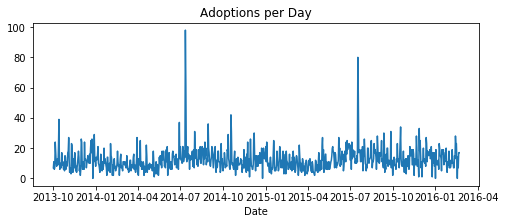

In [92]:
# Adoptions per Day
DayData = ExpandedData.groupby('Date')
DailyAdoptions = DayData['Adoption'].agg(np.sum)
DailyAdoptions.plot(title='Adoptions per Day', figsize =(8,3))


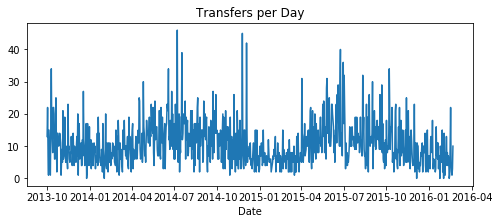

In [91]:
# Transfers per Day
DayData = ExpandedData.groupby('Date')
DailyTransfers = DayData['Transfer'].agg(np.sum)
DailyTransfers.plot(title='Transfers per Day', figsize =(8,3))

## Logistic Regression

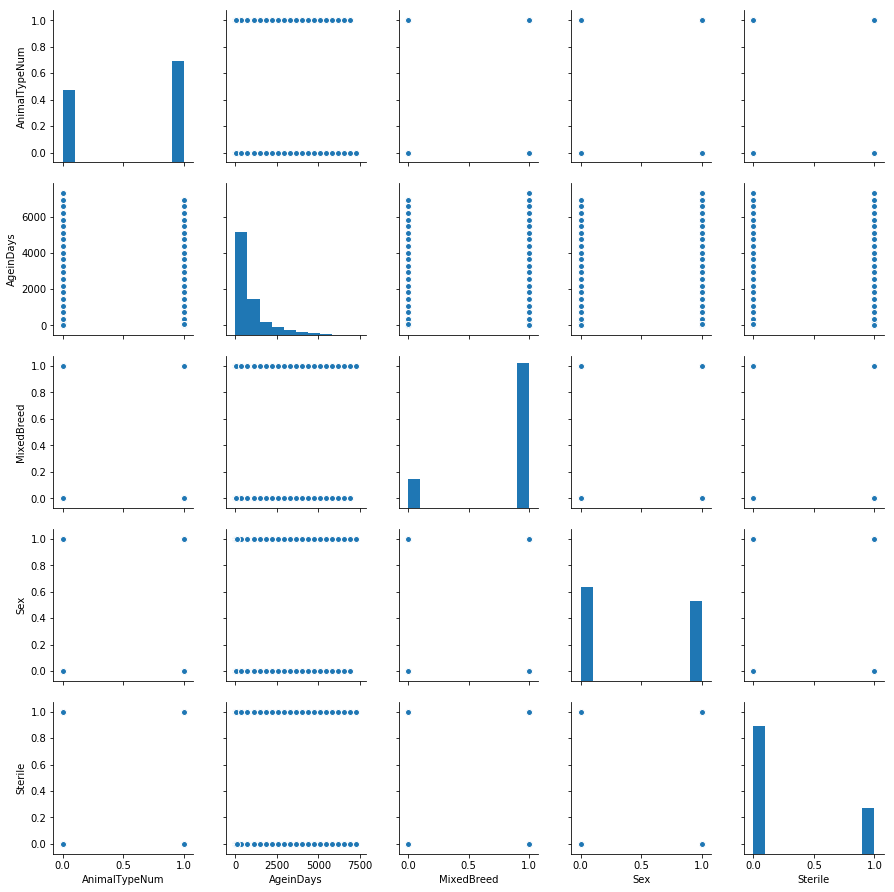

In [140]:
# plot Age and Adoption 
sns.pairplot(data)

In [ ]:
# Generate features and target
feature_cols = data.columns[9:14]
X = data[feature_cols]
y = data.OutcomeType

In [134]:
# Compute Logistic Regression to Predict Outcome
logreg = LogisticRegression()
logreg.fit(X,y)
OutcomePredLog = logreg.predict(X)

In [135]:
OutcomePredLog

array(['Adoption', 'Adoption', 'Adoption', ..., 'Adoption', 'Transfer',
       'Transfer'], dtype=object)

In [131]:
list(zip(feature_cols, logreg.coef_[0]))

[('AnimalTypeNum', 0.02144660795697088),
 ('AgeinDays', -0.0005633159392506033),
 ('MixedBreed', -0.06905357546328227),
 ('Sex', 0.47815419561159156),
 ('Sterile', -3.2176656733937103)]

In [137]:
y = data.OutcomeType
y_pred = OutcomePredLog
print("Model accuracy:",metrics.accuracy_score(y,y_pred))

Model accuracy: 0.5900332971678701


In [138]:
y_pred_probs = logreg.predict_proba(X)
y_pred_probs

array([[0.53801724, 0.00224174, 0.02530107, 0.23467742, 0.19976253],
       [0.62970147, 0.00443566, 0.02014898, 0.0369418 , 0.3087721 ],
       [0.49767137, 0.00224893, 0.03109504, 0.27596082, 0.19302385],
       ...,
       [0.40653812, 0.00222994, 0.04611566, 0.36794782, 0.17716846],
       [0.05103724, 0.03196112, 0.11227188, 0.02825332, 0.77647644],
       [0.04239577, 0.03128408, 0.13022549, 0.0332616 , 0.76283306]])

In [143]:
rf = RandomForestClassifier(n_estimators=50) #random forest with 50 trees

#train/test split with 10% of data in each split:
for i in range(10):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.1)
    rf_fit = rf.fit(X_train,y_train)
    print("Accuracy for split ",i,": ",metrics.accuracy_score(y_test,rf_fit.predict(X_test)))

#compute cross-validation score accuracy across 10 folds
cross_val_scores = cross_val_score(rf,X,y,cv=10)
print("10-fold accuracies:\n",cross_val_scores)
print("Mean cv-accuracy:",np.mean(cross_val_scores))
print("Std of cv-accuracy:",np.std(cross_val_scores))

Accuracy for split  0 :  0.632996632996633
Accuracy for split  1 :  0.6221473999251778
Accuracy for split  2 :  0.6213991769547325
Accuracy for split  3 :  0.6176580621025065
Accuracy for split  4 :  0.6307519640852974
Accuracy for split  5 :  0.6258885147774037
Accuracy for split  6 :  0.6434717545828657
Accuracy for split  7 :  0.6247661803217359
Accuracy for split  8 :  0.6195286195286195
Accuracy for split  9 :  0.6206509539842873
10-fold accuracies:
 [0.62990654 0.63401869 0.63126402 0.62341062 0.62864622 0.61728395
 0.61077844 0.6428304  0.62336204 0.64307116]
Mean cv-accuracy: 0.6284572093328071
Std of cv-accuracy: 0.009746333269416312


In [144]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() #create a scaler object
scaler.fit(X) #fit the scaler
X_scaled = scaler.transform(X) #transform the data with it

# compare original to standardized
print("original values:\n",X.values,"\n")
print("scaled values:\n",X_scaled,"\n")

# figure out how the standardization worked
print("Mean of each column:\n",scaler.mean_,"\n")
print("standard deviation of each column:\n",scaler.scale_,"\n")
print("Z-scoring the values by hand to make sure we arent crazy:\n",(X.values - scaler.mean_) / scaler.scale_)
print("Final Means of scaled data, per column:\n",X_scaled.mean(axis=0))
print("Final SD's of scaled data, per column:\n",X_scaled.std(axis=0))

original values:
 [[1.00e+00 3.65e+02 1.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 3.65e+02 1.00e+00 1.00e+00 0.00e+00]
 [1.00e+00 7.30e+02 1.00e+00 0.00e+00 0.00e+00]
 ...
 [1.00e+00 1.46e+03 1.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 2.80e+01 1.00e+00 0.00e+00 1.00e+00]
 [0.00e+00 3.65e+02 1.00e+00 0.00e+00 1.00e+00]] 

scaled values:
 [[ 0.84495371 -0.39615776  0.44577727 -0.92543957 -0.59773264]
 [-1.18349678 -0.39615776  0.44577727  1.08056759 -0.59773264]
 [ 0.84495371 -0.0589761   0.44577727 -0.92543957 -0.59773264]
 ...
 [ 0.84495371  0.61538721  0.44577727 -0.92543957 -0.59773264]
 [-1.18349678 -0.70747342  0.44577727 -0.92543957  1.67298877]
 [-1.18349678 -0.39615776  0.44577727 -0.92543957  1.67298877]] 

Mean of each column:
 [5.83448689e-01 7.93841782e+02 8.34224999e-01 4.61334131e-01
 2.63234689e-01] 

standard deviation of each column:
 [4.92987136e-01 1.08250255e+03 3.71878542e-01 4.98502709e-01
 4.40388678e-01] 

Z-scoring the values by hand to make sure we arent crazy:
 [[ 0.84

In [147]:
from sklearn.neighbors import KNeighborsClassifier
knn_unsc = KNeighborsClassifier(n_neighbors=3)
knn_sc = KNeighborsClassifier(n_neighbors=3)

X_wine_scaled = scaler.fit_transform(X)
y = data.OutcomeType
X_train,X_test,y_train,y_test = train_test_split(X_wine_scaled,y,
                                                 test_size=0.2,
                                                 random_state=1234)
X_train_unsc,X_test_unsc,y_train_unsc,y_test_unsc = train_test_split(X,
                                                                     y,
                                                                     test_size=0.2,
                                                                    random_state=1234)

knn_unsc.fit(X_train_unsc,y_train_unsc)
knn_sc.fit(X_train,y_train)
print("unscaled test accuracy:",metrics.accuracy_score(y_test_unsc,
                                                       knn_unsc.predict(X_test_unsc)))
print("scaled test accuracy:",metrics.accuracy_score(y_test,
                                                       knn_sc.predict(X_test)))

unscaled test accuracy: 0.5134680134680135
scaled test accuracy: 0.5312383090160868


In [151]:
rf = RandomForestRegressor(n_estimators=500, bootstrap=True, oob_score=True, random_state=12)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest RMSE:",np.sqrt(mean_squared_error(y_test,y_pred_rf)))

ValueError: could not convert string to float: 'Adoption'